<h1 align="center" style="font-family:Times New Roman;"> 
    <b> Group 17 </b>
</h1>

<h1 align="center" style="font-family:Times New Roman;"> 
    <b> Hourly Weather Data Analysis </b>
</h1>

<h2 align="right">Presentors:<br>
    Pranjal Jain<br>
    Samratsinh Dhumal<br>
    Snigdh Chandra<br>
</h2>

<h3><b> Introduction </b></h3>
<p>
We will be attempting to find the correlation between the weather conditions of different cities at different times and its cause on the occurrence of tornadoes and other weather events. Our main objective is to try to analyze, how the occurrence of a tornado depends on different weather conditions such as change in temperature or pressure or wind direction or speed.
</p>

<h3> <b>Dataset Description:</b> </h3>
<p>
1.	Dataset 1 - Historical Hourly Weather Data (USA). The above dataset contains around 5 years of hourly measurements data of various weather attributes, such as temperature, humidity, air pressure, etc. for the various cities in USA. <br>
2.	Dataset 2 - USA Historical Tornado. This dataset contains the details of tornadoes from 1950 to 2015. This contains features like the number of tornadoes, the latitudes and longitudes of the origin among others. <br>
3.	Dataset 3 - Longitudes and Latitudes of Cities in USA. This dataset contains the longitudes and latitudes of different American cities. <br>
</p>

## Creating Database and Importing Files

### Importing Packages

In [1]:
import os
import re
import csv
import sqlite3
from sqlite3 import Error
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('fivethirtyeight')
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import clear_output
%matplotlib inline

### Connecting to SQLite Function

In [2]:
def create_connection(db_file, delete_db=False):
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn

### Creating New Table Function

In [3]:
def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

### Selecting from Table Function

In [4]:
def select(conn,selct_sql):
    cur = conn.cursor()
    try:
        cur.execute(selct_sql)
        names = list(map(lambda x: x[0], cur.description))
        rows = cur.fetchall()
    except Error as e:
        names = e
        rows = []
    return [names,rows]

### Deleting from Table Function

In [5]:
def delete(conn,delete_sql):
    cur = conn.cursor()
    try:
        cur.execute(delete_sql)
    except Error as e:
        print("not deleted")

### Update Table function

In [6]:
def update(conn,update_sql):
    cur = conn.cursor()
    try:
        cur.execute(update_sql)
        #names = list(map(lambda x: x[0], cur.description))
        #rows = cur.fetchall()
        conn.commit()
    except Error as e:
        print("Failed to update")

### Create View

In [7]:
def create_view(conn, create_view_sql):
    try:
        c = conn.cursor()
        c.execute(create_view_sql)
    except Error as e:
        print(e)

### Function of converting .CSV File to SQLite File

In [8]:
def save_as_sql(file,conn,table_name,index=False):
    read_csv = pd.read_csv(file)
    read_csv.to_sql(table_name, conn, index)

### Creating Connection

In [9]:
conn = create_connection('weather_data',True)

### Saving Tables

In [10]:
save_as_sql('humidity.csv',conn,'humidity',False)
save_as_sql('city_attributes.csv',conn,'cities',False)
save_as_sql('pressure.csv',conn,'pressure',False)
save_as_sql('temperature.csv',conn,'temperature',False)
save_as_sql('weather_description.csv',conn,'weather_description',False)
save_as_sql('wind_direction.csv',conn,'wind_direction',False)
save_as_sql('wind_speed.csv',conn,'wind_speed',False)
save_as_sql('USA_Historical_Tornado_Snigdh.csv',conn,'USA_Historical_Tornado',False)
save_as_sql('USA_CityCoordinates.csv',conn,'USA_City_Coordinates',False)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:2712: UserWarning:

The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.



## Data Cleaning Process and Working on SQLite

### Deleting cities other than USA, empty rows, and cities with major missing values

In [11]:
delete(conn,"DELETE FROM cities WHERE country != 'United States'")
delete(conn,"DELETE FROM cities WHERE City = 'San Francisco'")
delete(conn,"DELETE FROM cities WHERE City = 'Miami'")
delete(conn,"DELETE FROM cities WHERE City = 'New York'")
delete(conn,"Delete FROM humidity where datetime = '2012-10-01 12:00:00'")
delete(conn,"Delete FROM pressure where datetime = '2012-10-01 12:00:00'")
delete(conn,"Delete FROM wind_speed where datetime = '2012-10-01 12:00:00'")
delete(conn,"Delete FROM wind_direction where datetime = '2012-10-01 12:00:00'")
delete(conn,"Delete FROM temperature where datetime = '2012-10-01 12:00:00'")

### Selecting all Cities of USA

In [12]:
[names,city_name] = select(conn,"Select city from cities")

### Updating Null Values in Tables

In [13]:
for city in city_name:
    humidity_nullvalues_update = """Update humidity set ["""+city[0]+"""] = (SELECT avg_val 
                                    from (Select AVG(h2.["""+city[0]+"""]) as avg_val, Substr(h2.datetime,1,7) 
                                    as tdatet FROM humidity as h2 group by Substr(h2.datetime,1,7)) as temp1 
                                    where Substr(humidity.datetime,1,7)=temp1.tdatet)
                                    where datetime not in (SELECT h1.datetime FROM 
                                    humidity as h1 where ["""+city[0]+"""] >= 0)"""
    update(conn,humidity_nullvalues_update)

    temperature_nullvalues_update = """Update temperature set ["""+city[0]+"""] = (SELECT avg_val 
                                       from (Select AVG(t2.["""+city[0]+"""]) as avg_val, Substr(t2.datetime,1,7) as tdatet FROM temperature as t2 group by Substr(t2.datetime,1,7)) as temp1 
                                       where Substr(temperature.datetime,1,7)=temp1.tdatet)
    where datetime not in (SELECT t2.datetime FROM temperature as t2 where  ["""+city[0]+"""] >= 0)"""
    update(conn,temperature_nullvalues_update)
    
    pressure_nullvalues_update = """Update pressure set ["""+city[0]+"""] = (SELECT avg_val 
                                       from (Select AVG(p2.["""+city[0]+"""]) as avg_val, Substr(p2.datetime,1,7) as tdatet FROM pressure as p2 group by Substr(p2.datetime,1,7)) as temp1 
                                       where Substr(pressure.datetime,1,7)=temp1.tdatet)
    where datetime not in (SELECT p2.datetime FROM pressure as p2 where  ["""+city[0]+"""] >= 0)"""
    update(conn,pressure_nullvalues_update)
    
    winddir_nullvalues_update = """Update wind_direction set ["""+city[0]+"""] = (SELECT avg_val 
                                       from (Select AVG(wd2.["""+city[0]+"""]) as avg_val, Substr(wd2.datetime,1,7) as tdatet FROM wind_direction as wd2 group by Substr(wd2.datetime,1,7)) as temp1 
                                       where Substr(wind_direction.datetime,1,7)=temp1.tdatet)
    where datetime not in (SELECT wd2.datetime FROM wind_direction as wd2 where  ["""+city[0]+"""] >= 0)"""
    update(conn,winddir_nullvalues_update)
    
    windsp_nullvalues_update = """Update wind_speed set ["""+city[0]+"""] = (SELECT avg_val 
                                       from (Select AVG(ws2.["""+city[0]+"""]) as avg_val, Substr(ws2.datetime,1,7) as tdatet FROM wind_speed as ws2 group by Substr(ws2.datetime,1,7)) as temp1 
                                       where Substr(wind_speed.datetime,1,7)=temp1.tdatet)
    where datetime not in (SELECT ws2.datetime FROM wind_speed as ws2 where  ["""+city[0]+"""] >= 0)"""
    update(conn,windsp_nullvalues_update)

### Function to Round City Coordinate to Join Two Tables  

In [14]:
def coord_round_dwn(a):
    if(a<0):
        b = math.floor(abs(a));
        return (b*(-1));
    else:
        return (round(a))
    
def getcities(tl):
    att = {}
    for at in tl:
        if(at in att):
            att[at] = att[at]+1;
        else:
            att[at] = 1
    #print(att)
    return(list(att.keys()))

### Updating State name

In [15]:
state_abbreviations = {"Alabama":"AL","Alaska":"AK","Arizona":"AZ","Arkansas":"AR","California":"CA","Colorado":"CO","Connecticut":"CT","Delaware":"DE","Florida":"FL","Georgia":"GA","Hawaii":"HI","Idaho":"ID","Illinois":"IL","Indiana":"IN","Iowa":"IA","Kansas":"KS","Kentucky":"KY","Louisiana":"LA","Maine":"ME","Maryland":"MD","Massachusetts":"MA","Michigan":"MI","Minnesota":"MN","Mississippi":"MS","Missouri":"MO","Montana":"MT","Nebraska":"NE","Nevada":"NV","New Hampshire":"NH","New Jersey":"NJ","New Mexico":"NM","New York":"NY","North Carolina":"NC","North Dakota":"ND","Ohio":"OH","Oklahoma":"OK","Oregon":"OR","Pennsylvania":"PA","Rhode Island":"RI","South Carolina":"SC","South Dakota":"SD","Tennessee":"TN","Texas":"TX","Utah":"UT","Vermont":"VT","Virginia":"VA","Washington":"WA","West Virginia":"WV","Wisconsin":"WI","Wyoming":"WY"}
for state in state_abbreviations:
    query = "Update USA_Historical_Tornado set st = '"+state+"' where USA_Historical_Tornado.st = '"+state_abbreviations[state]+"'"
    update(conn,query)

### Rounding Co-ordinate

In [16]:
import math
str0 = '''Select U2.City,U2.Latitude,U2.Longitude,U1.state_name,U1.lat,U1.lng 
        from USA_City_Coordinates as U1 INNER JOIN cities as U2 on U1.city = U2.City 
        WHERE U2.Country='United States' and 
        round(U1.lat) = round(U2.Latitude) and 
        round(U1.lng) = round(U2.Longitude)'''

[a,b] = select(conn,str0)
lama = []
asas = []
for l1 in b:
    l = (l1[0],coord_round_dwn(l1[1]),coord_round_dwn(l1[2]),l1[3],coord_round_dwn(l1[4]),coord_round_dwn(l1[5]))
    lama.append(l)
    asas.append(l[0])
final_cities = getcities(asas)

### Creating a joint table for all data

In [17]:
for city in city_name:
    str1 = """CREATE VIEW ["""+city[0]+"""_info] 
            (Date,Time,Humidity,Weather_Description,Pressure,Temperature,Wind_Direction,Wind_Speed)
             AS 
             Select Substr(h1.datetime,1,10),Substr(h1.datetime,12,19),h1.["""+city[0]+"""] as Humidity,wd1.["""+city[0]+"""] as Weather_Description,
             p1.["""+city[0]+"""] as Pressure,t1.["""+city[0]+"""] as Temperature,widir.["""+city[0]+"""] as Wind_Direction, wsp.["""+city[0]+"""] as Wind_Speed
             from humidity as h1 
             INNER JOIN weather_description as wd1 on h1.datetime=wd1.datetime 
             INNER JOIN pressure as p1 on h1.datetime=p1.datetime 
             INNER JOIN temperature as t1 on h1.datetime=t1.datetime 
             INNER JOIN wind_direction as widir on h1.datetime=widir.datetime 
             INNER JOIN wind_speed as wsp on h1.datetime=wsp.datetime"""
    
    create_view(conn,str1)

In [18]:
str20 = """CREATE VIEW CityDetails (City,StateName,Latitude,Longitude) AS Select U1.City,U1.state_name,U2.Latitude,U2.Longitude from USA_City_Coordinates as U1 INNER JOIN cities as U2 on U1.city = U2.City WHERE U2.Country='United States' and round(U1.lat) = round(U2.Latitude) and round(U1.lng) = round(U2.Longitude)"""
(create_view(conn,str20))

## Analysis

### Displaying Cities  

In [19]:
str2 = "SELECT name FROM sqlite_master WHERE type = 'view'"
[temp1,temp2] = select(conn,str2)
cityview_list = []
cityview_dict = {}
i = 0
for temp3 in temp2:
    cityview_list.append(temp3[0])
    cityview_dict[i] = temp3[0][:-5]
    i = i + 1
print(cityview_dict)

{0: 'Portland', 1: 'Seattle', 2: 'Los Angeles', 3: 'San Diego', 4: 'Las Vegas', 5: 'Phoenix', 6: 'Albuquerque', 7: 'Denver', 8: 'San Antonio', 9: 'Dallas', 10: 'Houston', 11: 'Kansas City', 12: 'Minneapolis', 13: 'Saint Louis', 14: 'Chicago', 15: 'Nashville', 16: 'Indianapolis', 17: 'Atlanta', 18: 'Detroit', 19: 'Jacksonville', 20: 'Charlotte', 21: 'Pittsburgh', 22: 'Philadelphia', 23: 'Boston', 24: 'CityDe'}


In [20]:
index1 = int(input("Please enter index number for desired city values:"))
print('\033[1m'+cityview_dict[index1]+" Data")
city_val = cityview_list[index1]
str3 = "SELECT * FROM ["+city_val+"]";
city_df = pd.read_sql_query(str3,conn)
city_df

Please enter index number for desired city values:10
Houston Data


,Date,Time,Humidity,Weather_Description,Pressure,Temperature,Wind_Direction,Wind_Speed
0,2012-10-01,13:00:00,93.0,sky is clear,1009.0,288.270000,270.0,1.0
1,2012-10-01,14:00:00,92.0,sky is clear,1008.0,288.297576,268.0,1.0
2,2012-10-01,15:00:00,90.0,sky is clear,1008.0,288.334343,265.0,1.0
3,2012-10-01,16:00:00,89.0,sky is clear,1008.0,288.371111,263.0,1.0
4,2012-10-01,17:00:00,88.0,few clouds,1008.0,288.407879,260.0,1.0
...,...,...,...,...,...,...,...,...
45247,2017-11-29,20:00:00,68.0,mist,1021.0,295.150000,344.0,2.0
45248,2017-11-29,21:00:00,73.0,haze,1021.0,295.820000,20.0,2.0
45249,2017-11-29,22:00:00,50.0,sky is clear,1020.0,296.370000,300.0,3.0
45250,2017-11-29,23:00:00,49.0,haze,1020.0,294.650000,290.0,2.0


### Plotting Given City and Parameter Over Years Function

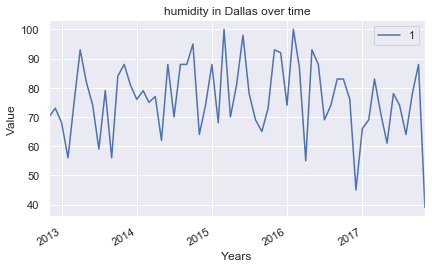

In [21]:
def years_plot(city='Dallas',parameter='humidity',frequency = 'M'):
    string = "Select datetime,\""+city+"\" from "+ parameter +";"
    [names,parameter_list] = select(conn,string)
    
    #converting to dataframe
    city_parameter = pd.DataFrame(parameter_list)
    
    #setting datetime as index
    city_parameter = city_parameter.set_index([0])
    city_parameter.index = pd.to_datetime(city_parameter.index)
    
    
    #plot
    sns.set()
    city_parameter.asfreq(frequency).plot()
    plt.title(parameter + ' in '+ city +' over time')
    plt.xlabel('Years')
    plt.ylabel('Value')
    plt.show()

##
years_plot('Dallas','humidity','M')

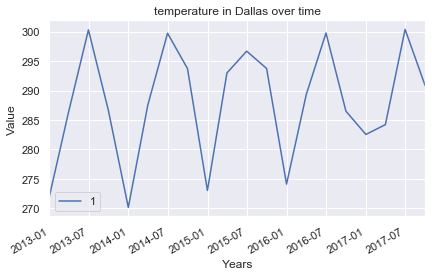

In [22]:
years_plot('Dallas','temperature','Q')

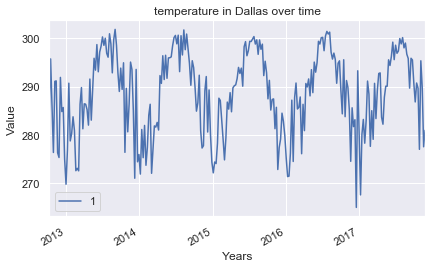

In [23]:
years_plot('Dallas','temperature','W')

### Plotting Given City and Parameter Over a Week Function

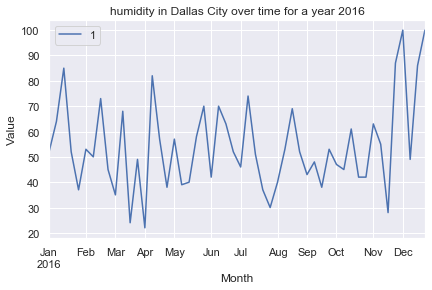

In [24]:
def yearly_plot(city='Dallas',parameter='humidity',frequency = 'M',year='2016'):  
    string = "Select datetime,\""+city+"\" from "+ parameter +" WHERE datetime LIKE '"+ str(year) +"%';"
    [names,parameter_list] = select(conn,string)
    
    #converting to dataframe
    city_parameter = pd.DataFrame(parameter_list)
    
    #setting datetime as index
    city_parameter = city_parameter.set_index([0])
    city_parameter.index = pd.to_datetime(city_parameter.index)
    
    #plot
    city_parameter.asfreq(frequency).plot()
    plt.title(parameter + ' in '+ city +' City over time for a year ' + str(year))
    plt.xlabel('Month')
    plt.ylabel('Value')
    plt.show()

    
##
yearly_plot('Dallas','humidity','W',2016)

### Plotting Given City and Parameter Distribution

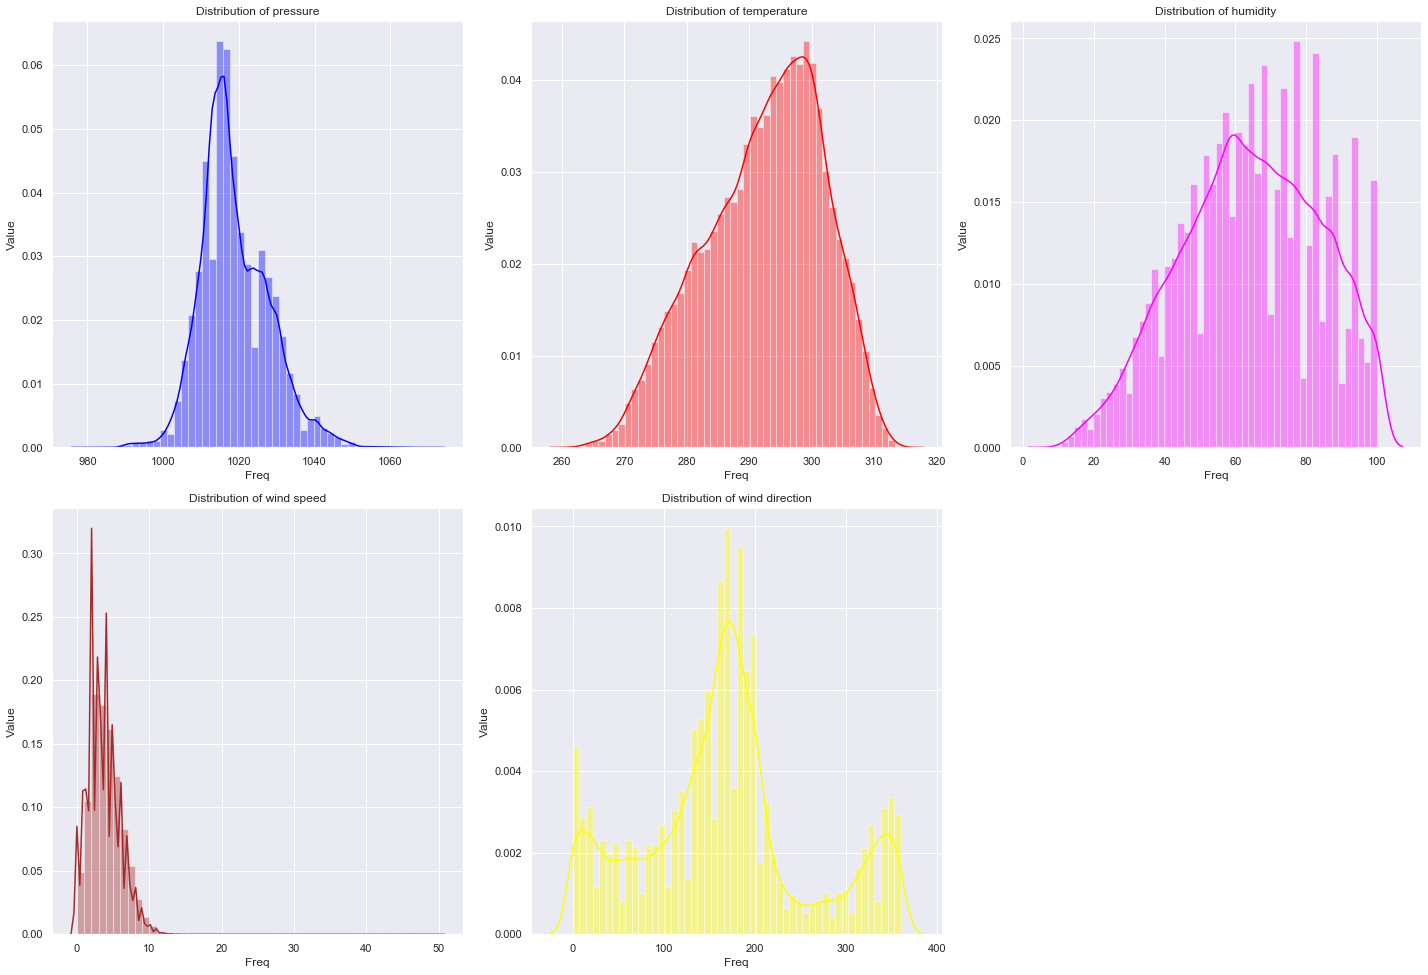

In [25]:
def city_parameter(city='Dallas'):
    
    plt.figure(figsize =(20,20))
    
    #defining subplot
    plt.subplot(3,3,1)
    
    string = "Select datetime,\""+city+"\" from pressure;"
    [names,pressure_list] = select(conn,string)
    
    #converting to dataframe
    city_pressure = pd.DataFrame(pressure_list)
    
    #setting datetime as index
    city_pressure = city_pressure.set_index([0])
    city_pressure.index = pd.to_datetime(city_pressure.index)
    
    city_pressure = city_pressure.dropna()
    
    sns.distplot(city_pressure,color='blue')
    plt.title('Distribution of pressure')
    plt.xlabel('Freq')
    plt.ylabel('Value')
    
    #defining subplot
    plt.subplot(3,3,2)
    
    string = "Select datetime,\""+city+"\" from temperature;"
    [names,temperature_list] = select(conn,string)
    
    #converting to dataframe
    city_temperature = pd.DataFrame(temperature_list)
    
    #setting datetime as index
    city_temperature = city_temperature.set_index([0])
    city_temperature.index = pd.to_datetime(city_temperature.index)
    
    city_temperature = city_temperature.dropna()
    
    sns.distplot(city_temperature,color='red')
    plt.title('Distribution of temperature')
    plt.xlabel('Freq')
    plt.ylabel('Value')
    
    #defining subplot
    plt.subplot(3,3,3)
    
    string = "Select datetime,\""+city+"\" from humidity;"
    [names,humidity_list] = select(conn,string)
    
    #converting to dataframe
    city_humidity = pd.DataFrame(humidity_list)
    
    #setting datetime as index
    city_humidity = city_humidity.set_index([0])
    city_humidity.index = pd.to_datetime(city_humidity.index)
    
    city_humidity = city_humidity.dropna()
    
    sns.distplot(city_humidity,color='magenta')
    plt.title('Distribution of humidity')
    plt.xlabel('Freq')
    plt.ylabel('Value')
    
    #defining subplot
    plt.subplot(3,3,4)
    
    string = "Select datetime,\""+city+"\" from wind_speed;"
    [names,windspeed_list] = select(conn,string)
    
    #converting to dataframe
    city_windspeed = pd.DataFrame(windspeed_list)
    
    #setting datetime as index
    city_windspeed = city_windspeed.set_index([0])
    city_windspeed.index = pd.to_datetime(city_windspeed.index)
    
    city_windspeed = city_windspeed.dropna()
    
    sns.distplot(city_windspeed,color='brown')
    plt.title('Distribution of wind speed')
    plt.xlabel('Freq')
    plt.ylabel('Value')
    
    #defining subplot
    plt.subplot(3,3,5)
    
    string = "Select datetime,\""+city+"\" from wind_direction;"
    [names,winddirection_list] = select(conn,string)
    
    #converting to dataframe
    city_winddirection = pd.DataFrame(winddirection_list)
    
    #setting datetime as index
    city_winddirection = city_winddirection.set_index([0])
    city_winddirection.index = pd.to_datetime(city_winddirection.index)
    
    city_winddirection = city_winddirection.dropna()
    
    sns.distplot(city_winddirection,color='yellow')
    plt.title('Distribution of wind direction')
    plt.xlabel('Freq')
    plt.ylabel('Value')
    
    plt.tight_layout()
    plt.show()
    
##
city_parameter("Dallas")

### Parameter Relation Function

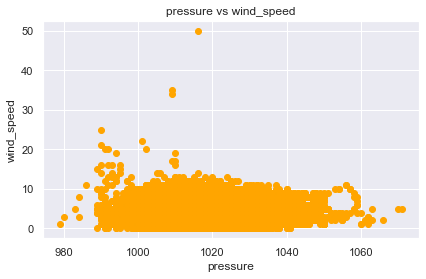

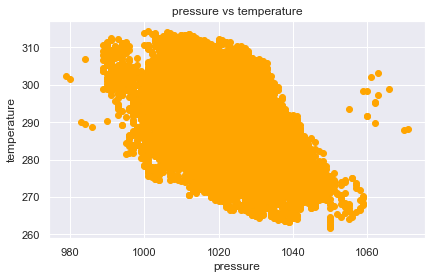

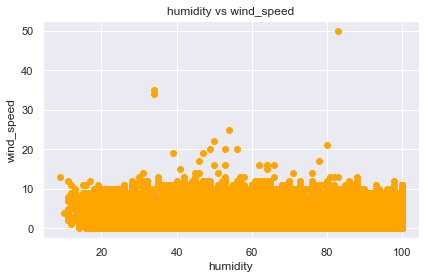

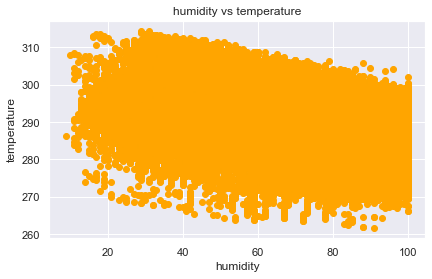

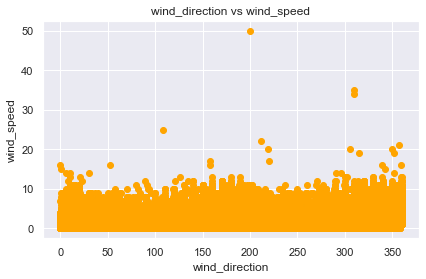

In [26]:
def parameter_relation(city='Dallas',parameter1='humdity',parameter2='temperature'):
    
    string = "Select datetime,\""+city+"\" from "+ parameter1 +";"
    [names,parameter1_list] = select(conn,string)
    
    #converting to dataframe
    city_parameter1 = pd.DataFrame(parameter1_list)
    
    #setting datetime as index
    city_parameter1 = city_parameter1.set_index([0])
    city_parameter1.index = pd.to_datetime(city_parameter1.index)
    
    #city_parameter1 = city_parameter1.dropna()
    
    string = "Select datetime,\""+city+"\" from "+ parameter2 +";"
    [names,city_parameter2_list] = select(conn,string)
    
    #converting to dataframe
    city_parameter2 = pd.DataFrame(city_parameter2_list)
    
    #setting datetime as index
    city_parameter2 = city_parameter2.set_index([0])
    city_parameter2.index = pd.to_datetime(city_parameter2.index)
    
    #city_parameter2 = city_parameter2.dropna()
    
    plt.scatter(x=city_parameter1,y=city_parameter2,color='orange')
    plt.title(parameter1 + ' vs '+ parameter2)
    plt.xlabel(parameter1)
    plt.ylabel(parameter2)
    plt.show()
    
##
parameter_relation('Dallas','pressure','wind_speed')
parameter_relation('Dallas','pressure','temperature')
parameter_relation('Dallas','humidity','wind_speed')
parameter_relation('Dallas','humidity','temperature')
parameter_relation('Dallas','wind_direction','wind_speed')

### Weather Description Function

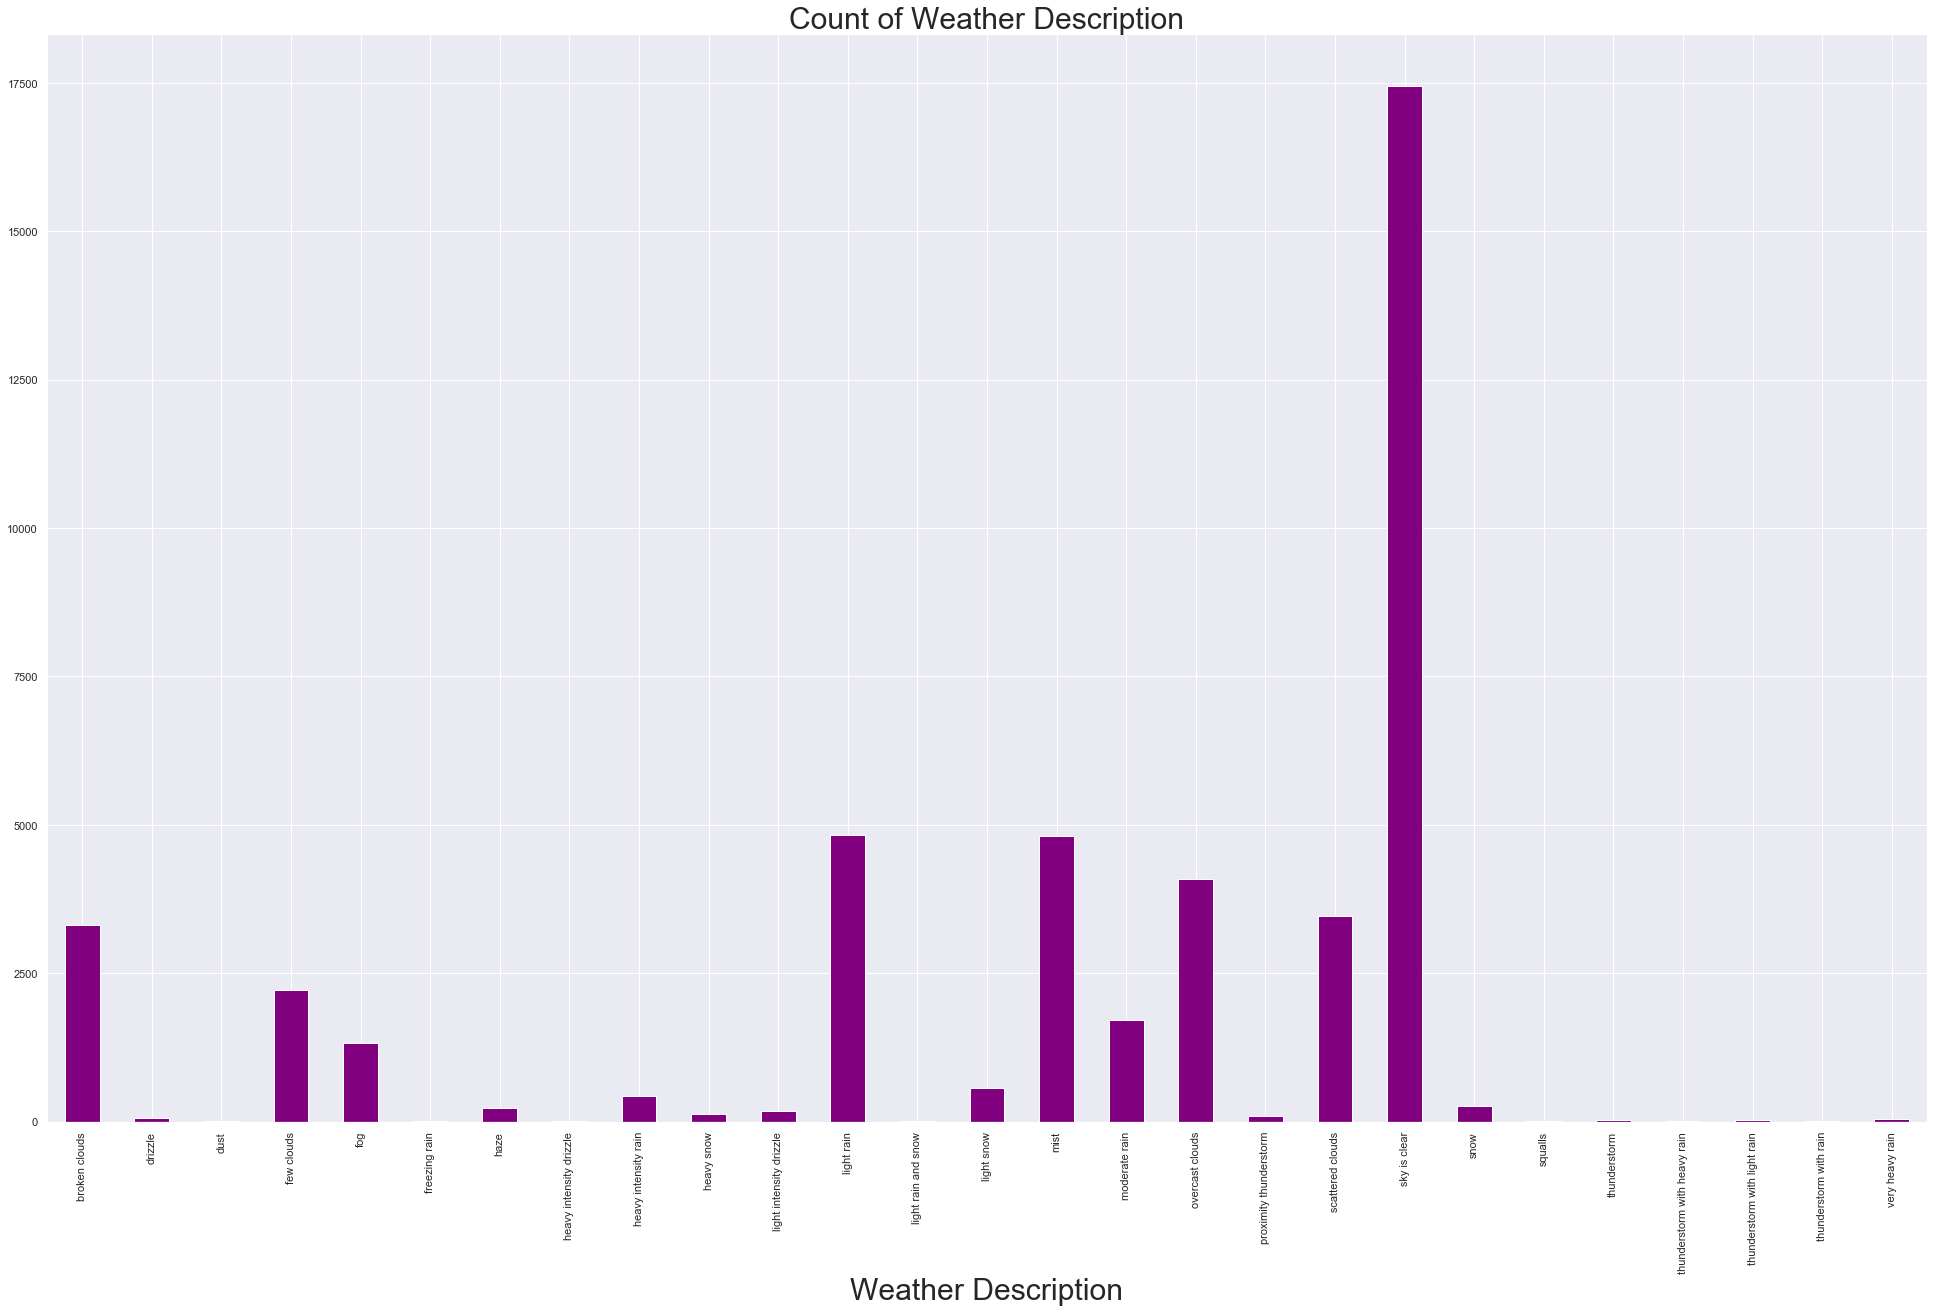

In [27]:
def city_weather_description(city='Boston'):
    
    plt.figure(figsize=(30,20))
    
    string = """Select p.datetime,p.["""+city+"""],wd.["""+city+"""]
                 from pressure as p
                 INNER JOIN weather_description as wd on p.datetime=wd.datetime"""
    
    [names,pressure_description_list] = select(conn,string)
    
    #converting to dataframe
    city_pressure_description = pd.DataFrame(pressure_description_list)
    
    #setting datetime as index
    city_pressure_description = city_pressure_description.set_index([0])
    city_pressure_description.index = pd.to_datetime(city_pressure_description.index)
    
    plt.rcParams.update({'font.size': 20})
    city_pressure_description.groupby(2).count()[1].plot(kind='bar',color='purple')
    plt.title('Count of Weather Description',fontsize= 30)
    plt.xlabel('Weather Description', fontsize= 30)
    plt.rcParams.update({'font.size': 30})
    plt.show()
    plt.rcdefaults()
    
city_weather_description()

### City Monthly Parameter Fluctuation Function

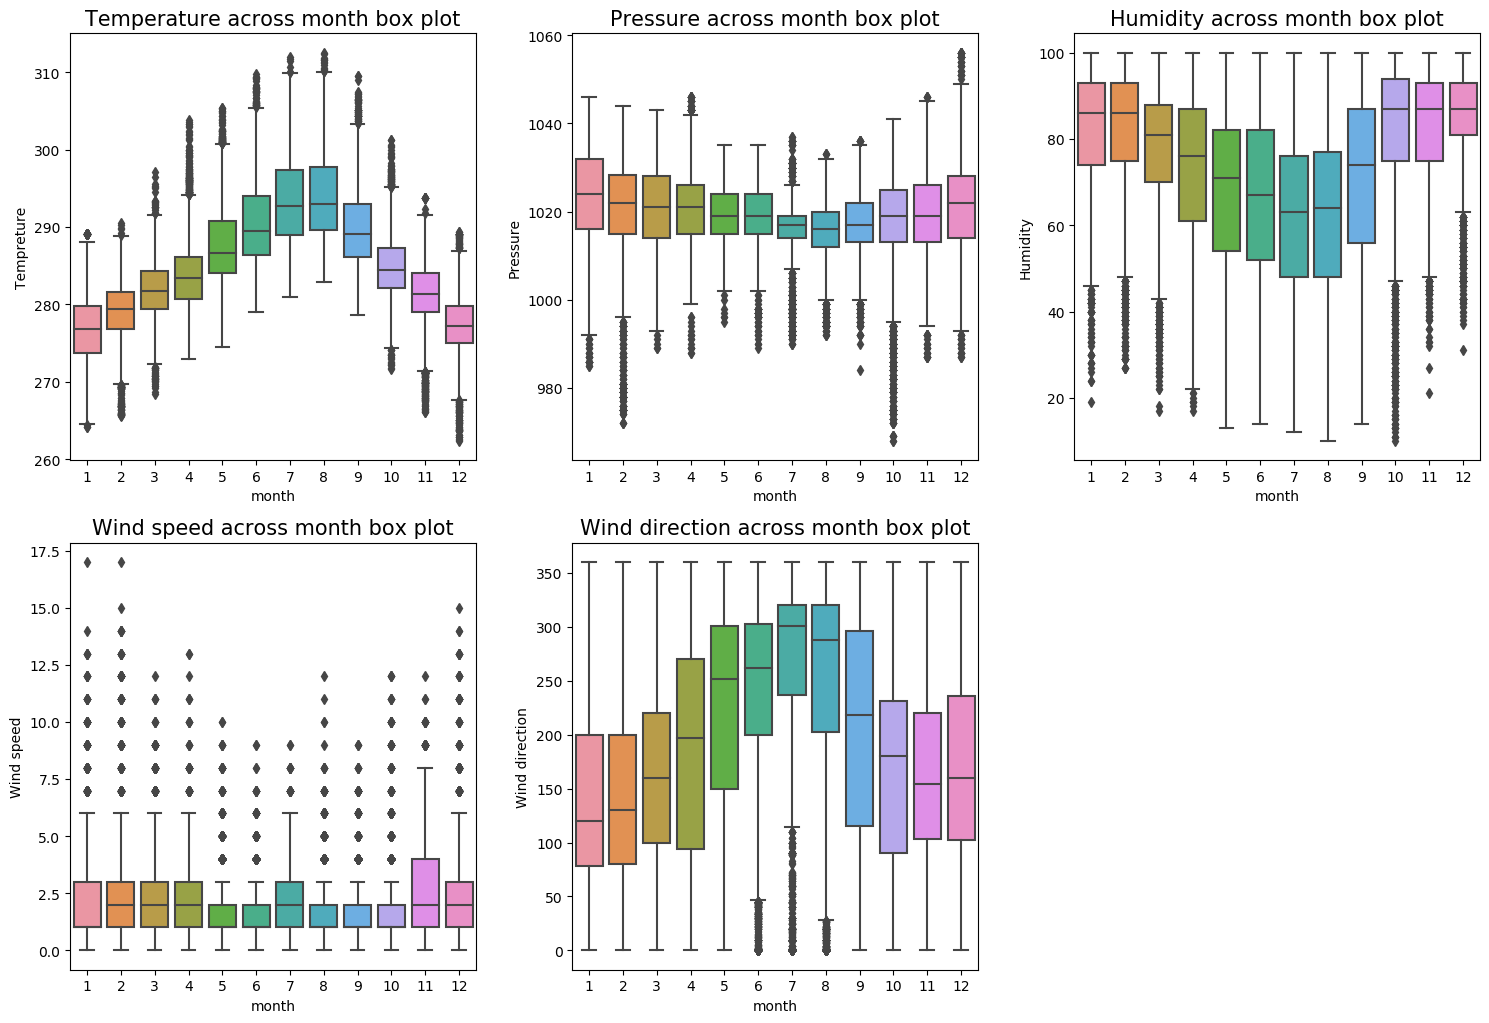

In [28]:
def parameter_monthly_flctuations(city='Portland'):
    
    #plot figure
    plt.figure(figsize=(15,15))
    
    #SQL
    string = "Select datetime,\""+city+"\" from temperature;"
    [names,temperature_list] = select(conn,string)

    #convert ing to dataframe
    city_temperature = pd.DataFrame(temperature_list)

    #setting datetime as index
    time = pd.DatetimeIndex(city_temperature[0])
    city_temperature['month']=time.month

    plt.subplot(3,3,1)
    plot_temperature = sns.boxplot(x='month',y=1,data=city_temperature)
    plot_temperature.set(ylabel="Tempreture")
    plt.title('Temperature across month box plot', fontsize = 15)
    
    #SQL
    string = "Select datetime,\""+city+"\" from pressure;"
    [names,pressure_list] = select(conn,string)

    #convert ing to dataframe
    city_pressure = pd.DataFrame(pressure_list)

    #setting datetime as index
    time = pd.DatetimeIndex(city_pressure[0])
    city_pressure['month']=time.month
    
    plt.subplot(3,3,2)
    plot_pressure = sns.boxplot(x='month',y=1,data=city_pressure)
    plot_pressure.set(ylabel="Pressure")
    plt.title('Pressure across month box plot', fontsize = 15)
    
    #SQL
    string = "Select datetime,\""+city+"\" from humidity;"
    [names,humidity_list] = select(conn,string)

    #convert ing to dataframe
    city_humidity = pd.DataFrame(humidity_list)

    #setting datetime as index
    time = pd.DatetimeIndex(city_humidity[0])
    city_humidity['month']=time.month
    
    plt.subplot(3,3,3)
    plot_humidity = sns.boxplot(x='month',y=1,data=city_humidity)
    plot_humidity.set(ylabel="Humidity")
    plt.title('Humidity across month box plot', fontsize = 15)
    
    #SQL
    string = "Select datetime,\""+city+"\" from wind_speed;"
    [names,windspeed_list] = select(conn,string)

    #convert ing to dataframe
    city_windspeed = pd.DataFrame(windspeed_list)

    #setting datetime as index
    time = pd.DatetimeIndex(city_windspeed[0])
    city_windspeed['month']=time.month
    
    plt.subplot(3,3,4)
    plot_windspeed = sns.boxplot(x='month',y=1,data=city_windspeed)
    plot_windspeed.set(ylabel="Wind speed")
    plt.title('Wind speed across month box plot', fontsize = 15)
    
    #SQL
    string = "Select datetime,\""+city+"\" from wind_direction;"
    [names,winddirection_list] = select(conn,string)

    #convert ing to dataframe
    city_winddirection = pd.DataFrame(winddirection_list)

    #setting datetime as index
    time = pd.DatetimeIndex(city_winddirection[0])
    city_winddirection['month']=time.month
    
    plt.subplot(3,3,5)
    plot_winddirection = sns.boxplot(x='month',y=1,data=city_winddirection)
    plot_winddirection.set(ylabel="Wind direction")
    
    plt.title('Wind direction across month box plot', fontsize = 15)
    plt.tight_layout()
    plt.show()
parameter_monthly_flctuations()

### City Weekly Parameter Fluctuation Function

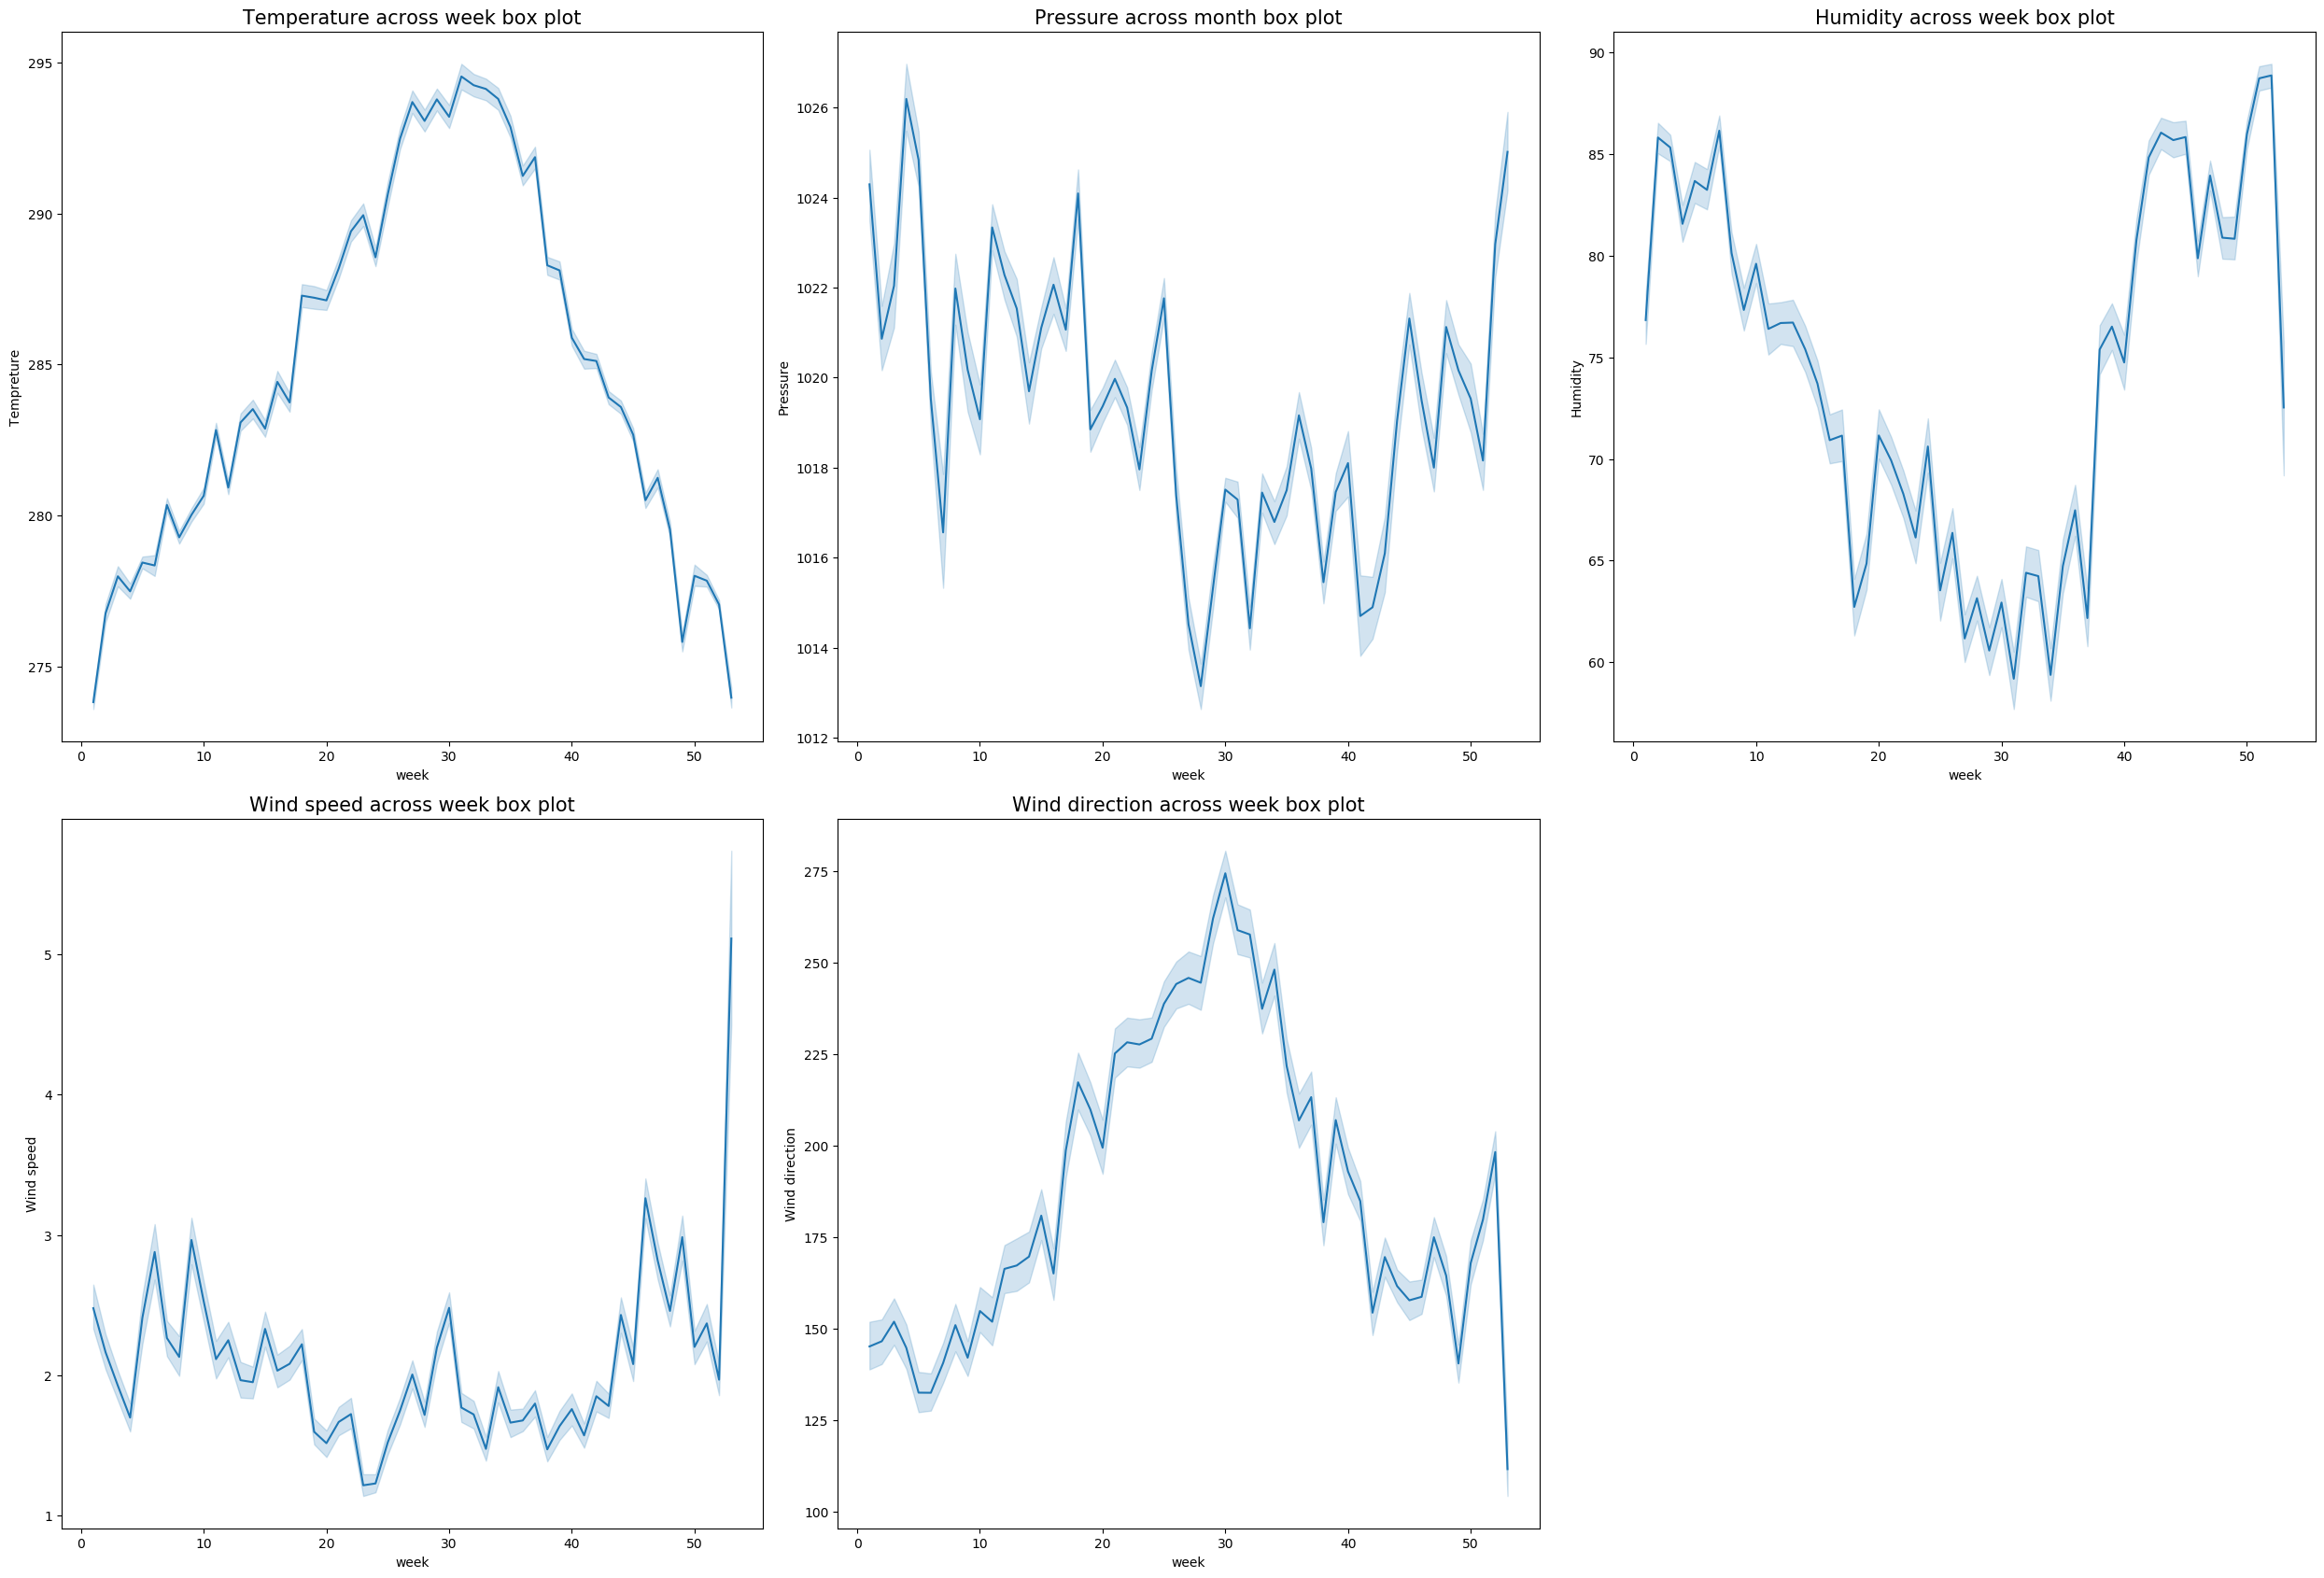

In [29]:
def parameter_weekly_flctuations(city='Portland'):

    #plot figure
    plt.figure(figsize=(25,25))

    #SQL
    string = "Select datetime,\""+city+"\" from temperature;"
    [names,temperature_list] = select(conn,string)

    #convert ing to dataframe
    city_temperature = pd.DataFrame(temperature_list)

    #setting datetime as index
    time = pd.DatetimeIndex(city_temperature[0])
    city_temperature['week']=time.week

    plt.subplot(3,3,1)
    plot_temperature = sns.lineplot(x='week',y=1,data=city_temperature)
    plot_temperature.set(ylabel="Tempreture")
    plt.title('Temperature across week box plot', fontsize = 15)

    #SQL
    string = "Select datetime,\""+city+"\" from pressure;"
    [names,pressure_list] = select(conn,string)

    #convert ing to dataframe
    city_pressure = pd.DataFrame(pressure_list)

    #setting datetime as index
    time = pd.DatetimeIndex(city_pressure[0])
    city_pressure['week']=time.week

    plt.subplot(3,3,2)
    plot_pressure = sns.lineplot(x='week',y=1,data=city_pressure)
    plot_pressure.set(ylabel="Pressure")
    plt.title('Pressure across month box plot', fontsize = 15)

    #SQL
    string = "Select datetime,\""+city+"\" from humidity;"
    [names,humidity_list] = select(conn,string)

    #convert ing to dataframe
    city_humidity = pd.DataFrame(humidity_list)

    #setting datetime as index
    time = pd.DatetimeIndex(city_humidity[0])
    city_humidity['week']=time.week

    plt.subplot(3,3,3)
    plot_humidity = sns.lineplot(x='week',y=1,data=city_humidity)
    plot_humidity.set(ylabel="Humidity")
    plt.title('Humidity across week box plot', fontsize = 15)

    #SQL
    string = "Select datetime,\""+city+"\" from wind_speed;"
    [names,windspeed_list] = select(conn,string)

    #convert ing to dataframe
    city_windspeed = pd.DataFrame(windspeed_list)

    #setting datetime as index
    time = pd.DatetimeIndex(city_windspeed[0])
    city_windspeed['week']=time.week

    plt.subplot(3,3,4)
    plot_windspeed = sns.lineplot(x='week',y=1,data=city_windspeed)
    plot_windspeed.set(ylabel="Wind speed")
    plt.title('Wind speed across week box plot', fontsize = 15)

    #SQL
    string = "Select datetime,\""+city+"\" from wind_direction;"
    [names,winddirection_list] = select(conn,string)

    #convert ing to dataframe
    city_winddirection = pd.DataFrame(winddirection_list)

    #setting datetime as index
    time = pd.DatetimeIndex(city_winddirection[0])
    city_winddirection['week']=time.week

    plt.subplot(3,3,5)
    plot_winddirection = sns.lineplot(x='week',y=1,data=city_winddirection)
    plot_winddirection.set(ylabel="Wind direction")

    plt.title('Wind direction across week box plot', fontsize = 15)
    plt.tight_layout()
    plt.show()
parameter_weekly_flctuations()

## Plotly Plot on Weather and Tornado Datasets

In [30]:
Yr_df = pd.read_sql_query("SELECT DISTINCT Yr from USA_Historical_Tornado", conn)
Tor_df = pd.read_sql_query("SELECT st,len,\"start lat\",\"start lon\",\"fin lat\",\"fin lon\" from USA_Historical_Tornado WHERE Yr = 1950", conn)
City_at_df = pd.read_sql_query("Select City,Latitude,Longitude from cities WHERE country = 'United States'", conn)

In [31]:
Yr_list = Yr_df['Yr'].values.tolist()

In [32]:
m=widgets.Dropdown(
    options=Yr_list,
    description='Year:',
    disabled=False,
)
display(m)
fig = go.Figure()


fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = Tor_df['start lon'],
        lat = Tor_df['start lat'],
        text = Tor_df['st'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = False,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=0.1,
                color='black'
            ),
            colorscale = 'darkmint',
            cmin = 0,
            color = Tor_df['len'],
            cmax = Tor_df['len'].max(),
            colorbar_title="Length of Tornadoes"
        )))

fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    text = City_at_df['City'],   
    lon = City_at_df['Longitude'],
    lat = City_at_df['Latitude'],
    mode = 'markers+text',
    textposition = 'bottom center',
    marker_color = 'maroon',
    ))


fig.update_layout(
    title_text = 'Tornadoes in the Year 1950',
    showlegend = False,
    geo = go.layout.Geo(
        scope = 'usa',
        projection_type = 'albers usa',
        showland = True,
        landcolor = 'lightgray',
        countrycolor = 'white',
    ),
)

fig.show()

def on_change(change):
    clear_output()
    display(m)
    input_val=str(change['owner'])[-5:-1]
    Tor_df = pd.read_sql_query("SELECT st,len,\"start lat\",\"start lon\",\"fin lat\",\"fin lon\" from USA_Historical_Tornado WHERE Yr ="+input_val, conn)
    
    fig = go.Figure()

    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = Tor_df['start lon'],
        lat = Tor_df['start lat'],
        text = Tor_df['st'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = False,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=0.1,
                color='black'
            ),
            colorscale = 'darkmint',
            cmin = 0,
            color = Tor_df['len'],
            cmax = Tor_df['len'].max(),
            colorbar_title="Length of Tornadoes"
    )))

    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        text = City_at_df['City'],   
        lon = City_at_df['Longitude'],
        lat = City_at_df['Latitude'],
        mode = 'markers+text',
        textposition = 'bottom center',
        marker_color = 'maroon',
    ))


    fig.update_layout(
        title_text = 'Tornadoes in the Year '+input_val,
        showlegend = False,
        geo = go.layout.Geo(
            scope = 'usa',
            projection_type = 'albers usa',
            showland = True,
            landcolor = 'lightgray',
            countrycolor = 'white',
        ),
    )

    fig.show()
m.observe(on_change)
    

Dropdown(description='Year:', index=65, options=(1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1…

### Joining Weather and Tornado Datasets

In [33]:
for city in final_cities:
    str12 = """CREATE VIEW ["""+city+"""_More_Info] (Date,Time,City,State,Len,Start_lat,Start_Lon,Final_Lat,Final_Long) 
        AS 
        Select UHT.date,UHT.Time,CD.City,CD.StateName,UHT.len,UHT.[start lat],UHT.[start lon],UHT.[fin lat],UHT.[fin lon] 
        from USA_Historical_Tornado as UHT INNER JOIN CityDetails as CD on CD.City = '"""+city+"""' 
        WHERE cast(CD.Latitude as INT)=cast([start lat] as INT) and cast(CD.Longitude as INT)=cast([fin lon] as INT)""" 
    create_view(conn,str12)

In [34]:
for city_name in final_cities:
    newquery = """CREATE 
        VIEW ["""+city_name+"""_Final] (Date,State,Humidity,Pressure,Temperature,Wind_Dir,Wind_Speed,Len,Start_lat,Start_Lon,Final_Lat,Final_Lon) 
        AS 
        Select DMI.Date,DMI.State,DI.Humidity,DI.Pressure,DI.Temperature,DI.Wind_Direction,DI.Wind_Speed,DMI.Len,DMI.Start_lat,DMI.Start_Lon,DMI.Final_Lat,DMI.Final_Long 
        FROM ["""+city_name+"""_More_Info] as DMI INNER JOIN ["""+city_name+"""_info] as DI on DMI.Date=DI.Date 
        WHERE DMI.Date = DI.Date"""
    
    create_view(conn,newquery)

In [35]:
df_dallas = pd.read_sql_query("SELECT * from Dallas_Final",conn)
df_dallas

,Date,State,Humidity,Pressure,Temperature,Wind_Dir,Wind_Speed,Len,Start_lat,Start_Lon,Final_Lat,Final_Lon
0,2013-05-15,Texas,22.0,1020.0,302.530000,180.0,4.0,6.17,32.3250,-96.6310,32.3640,-96.5360
1,2013-05-15,Texas,29.0,1019.0,301.390000,117.0,1.0,6.17,32.3250,-96.6310,32.3640,-96.5360
2,2013-05-15,Texas,34.0,1020.0,299.510000,143.0,0.0,6.17,32.3250,-96.6310,32.3640,-96.5360
3,2013-05-15,Texas,37.0,1020.0,298.000000,250.0,0.0,6.17,32.3250,-96.6310,32.3640,-96.5360
4,2013-05-15,Texas,33.0,1021.0,296.770000,190.0,4.0,6.17,32.3250,-96.6310,32.3640,-96.5360
...,...,...,...,...,...,...,...,...,...,...,...,...
307,2015-12-26,Texas,83.0,1005.0,297.240000,160.0,9.0,13.04,32.7960,-96.5894,32.9669,-96.4950
308,2015-12-26,Texas,83.0,1005.0,297.157178,160.0,9.0,1.58,32.3340,-97.0120,32.3510,-96.9940
309,2015-12-26,Texas,83.0,1005.0,297.157178,160.0,9.0,8.52,32.4623,-96.9090,32.5699,-96.8376
310,2015-12-26,Texas,83.0,1005.0,297.157178,160.0,9.0,5.08,32.3855,-96.5300,32.4566,-96.5080


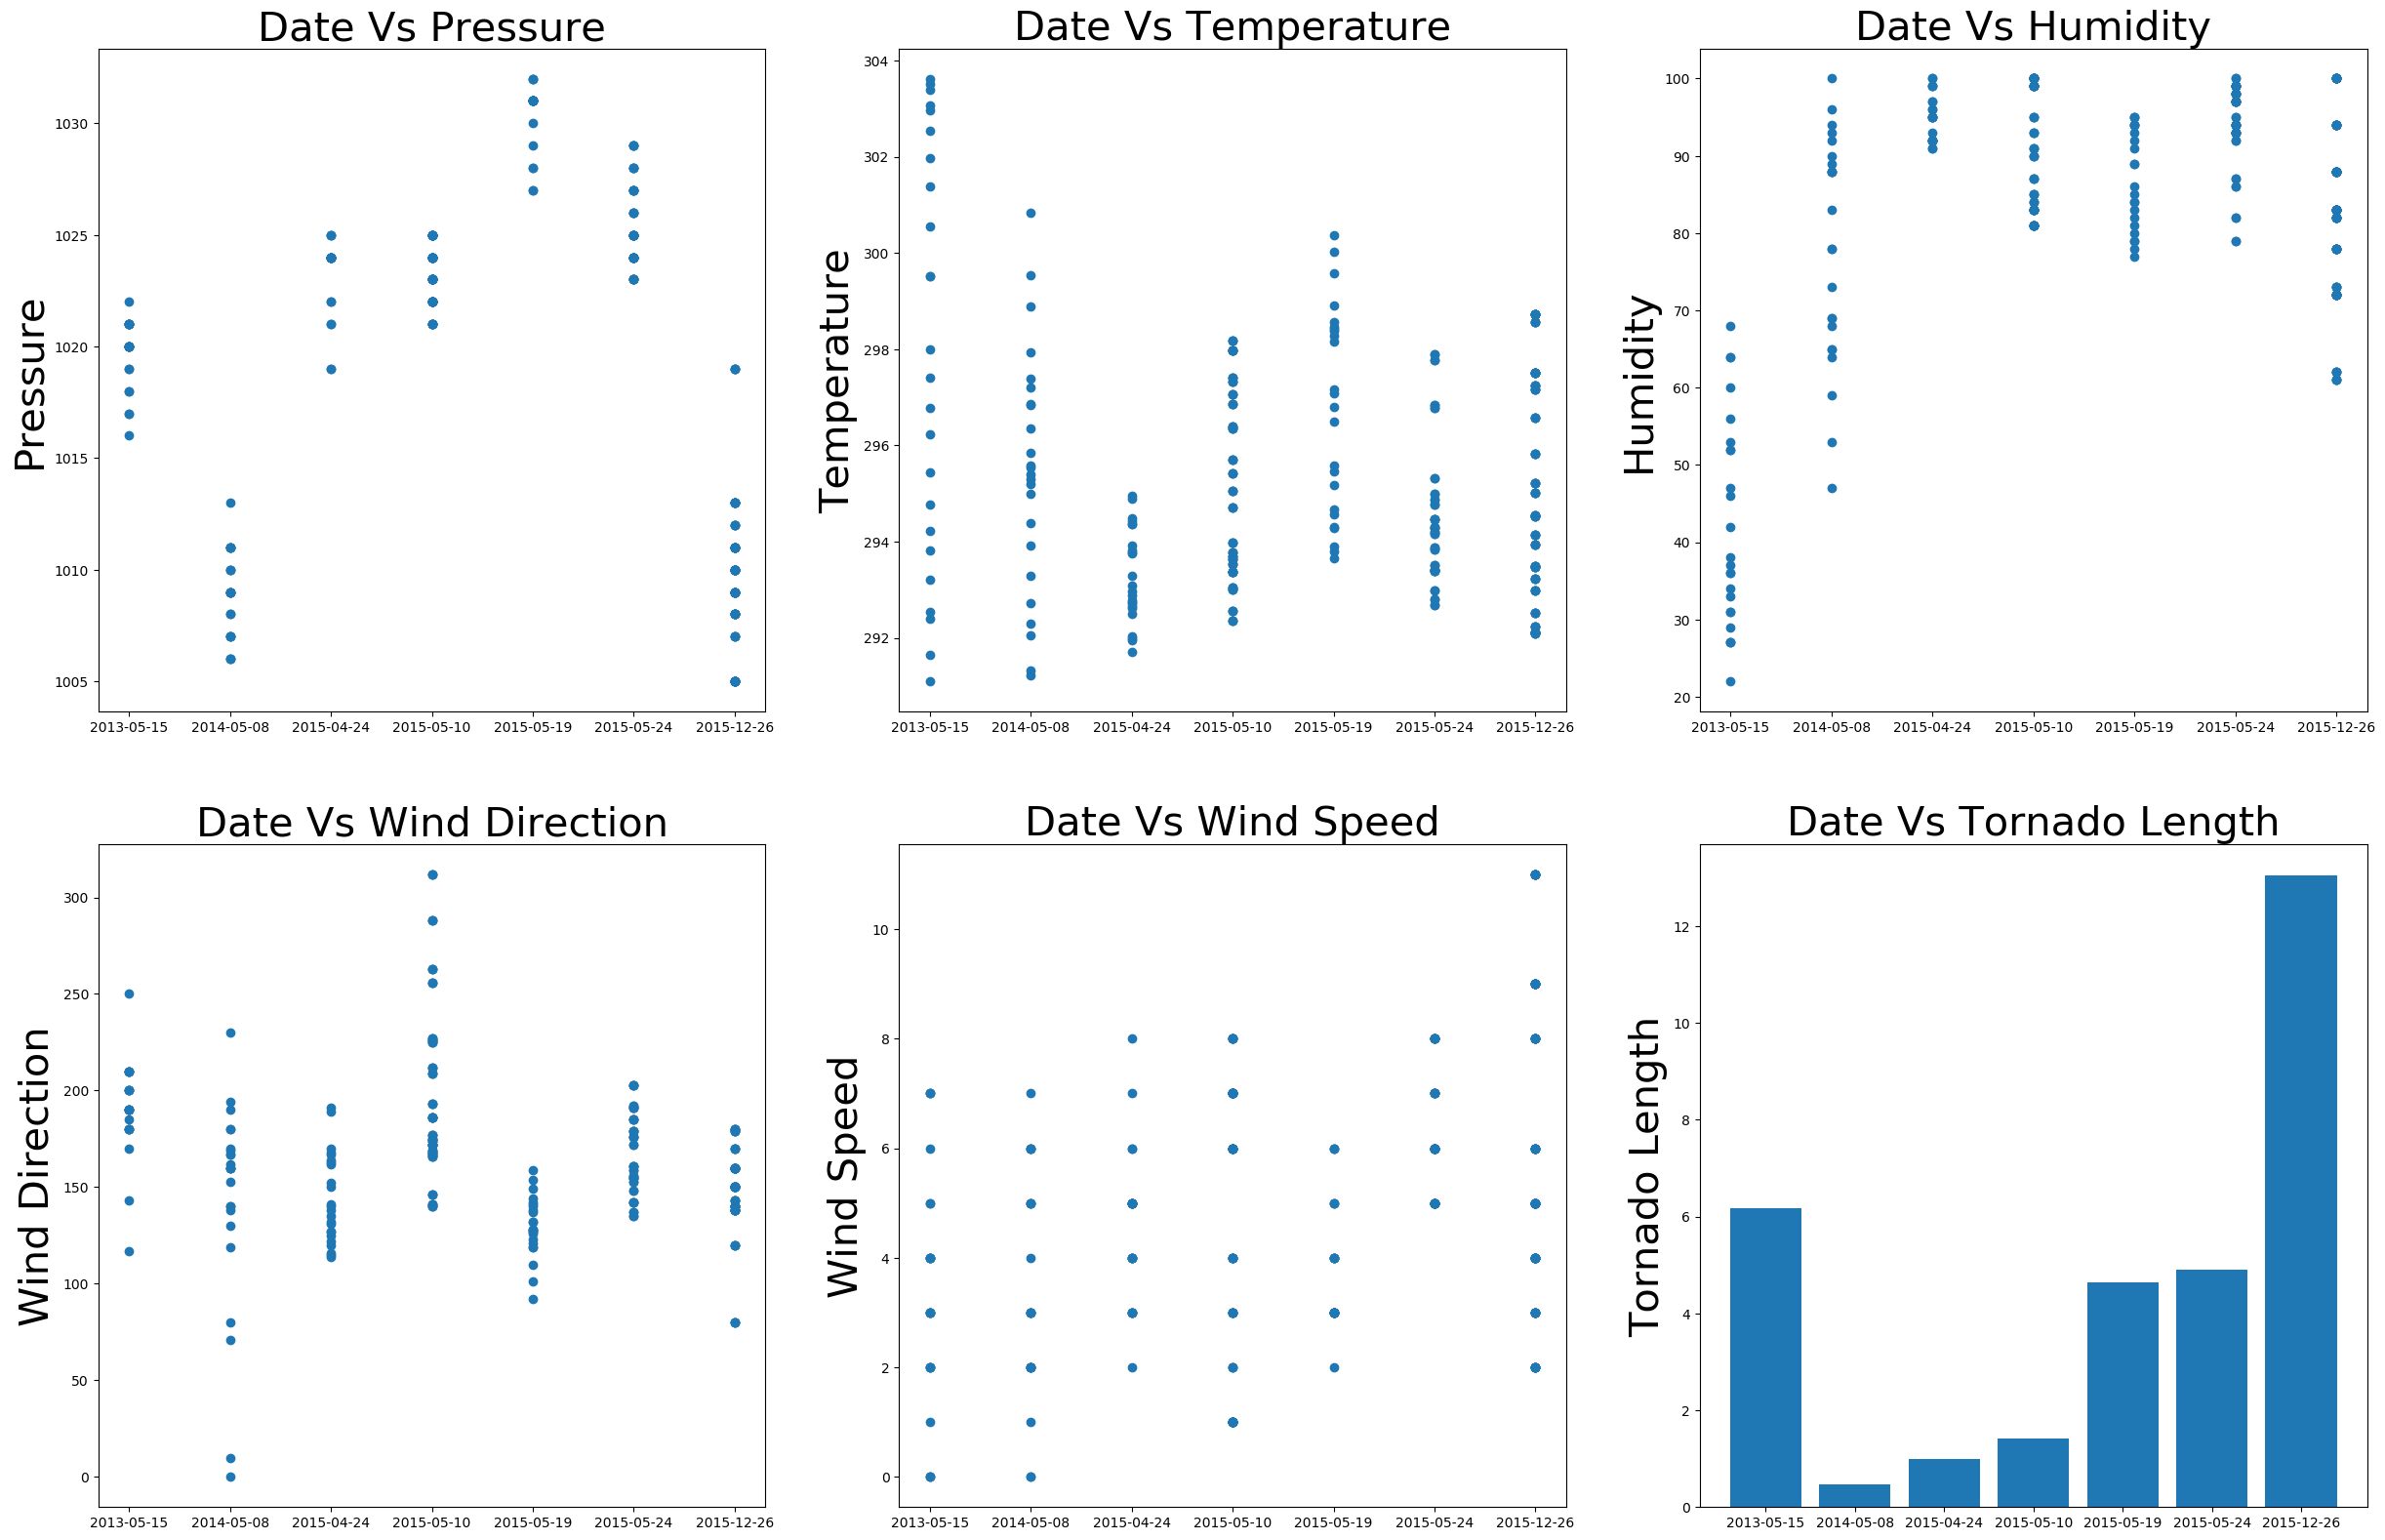

In [36]:
    plt.figure(figsize=(30,30))
    
    plt.subplot(3,3,1)
    plt.scatter(df_dallas['Date'],df_dallas['Pressure'])
    plt.title('Date Vs Pressure',fontsize= 30)
    plt.ylabel('Pressure', fontsize= 30)
    
    plt.subplot(3,3,2)
    plt.scatter(df_dallas['Date'],df_dallas['Temperature'])
    plt.title('Date Vs Temperature',fontsize= 30)
    plt.ylabel('Temperature', fontsize= 30)
    
    plt.subplot(3,3,3)
    plt.scatter(df_dallas['Date'],df_dallas['Humidity'])
    plt.title('Date Vs Humidity',fontsize= 30)
    plt.ylabel('Humidity', fontsize= 30)
    
    plt.subplot(3,3,4)
    plt.scatter(df_dallas['Date'],df_dallas['Wind_Dir'])
    plt.title('Date Vs Wind Direction',fontsize= 30)
    plt.ylabel('Wind Direction', fontsize= 30)
    
    plt.subplot(3,3,5)
    plt.scatter(df_dallas['Date'],df_dallas['Wind_Speed'])
    plt.title('Date Vs Wind Speed',fontsize= 30)
    plt.ylabel('Wind Speed', fontsize= 30)
    
    plt.subplot(3,3,6)
    plt.bar(df_dallas['Date'],df_dallas['Len'])
    plt.title('Date Vs Tornado Length',fontsize= 30)
    plt.ylabel('Tornado Length', fontsize= 30)
    
    
    plt.show()
    plt.rcdefaults()